In [4]:
%load_ext autoreload
%autoreload 2

# https://www.ishares.com/us/products/239706/ishares-russell-1000-growth-etf
# https://aroussi.com/post/python-yahoo-finance
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import pandas as pd
import pickle
import scipy.stats as stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Download Yahoo Data (5 minute interval)

In [5]:
import YahooStocks

tix = "MSFT AAPL GOOG TSLA AMZN FB KIRK V MA UNH NFLX CRM NKE HD COST KO AMT LOW UPS ZM MMM"
# Initialize
stocks = YahooStocks.Stocks(tix)
# Download Yahoo and transform
stocks.get_data(interval = '15m')
stocks.transform_data()
# Write to transformed data to SQL
stocks.insert_SQL()
# Read from SQL
stocks.read_SQL('stockprice')

[*********************100%***********************]  21 of 21 completed


In [6]:
stocks.raw_data.shape

(130, 126)

In [7]:
stocks.transformed_data.to_csv('data/mydata.csv')

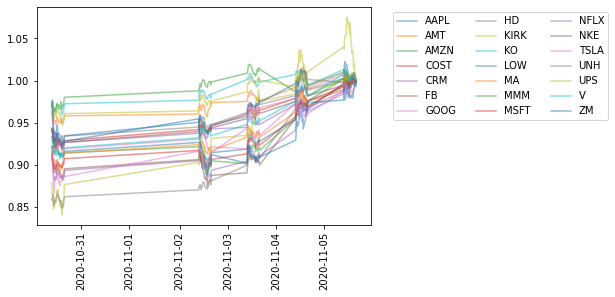

In [8]:
stocks.plot_raw(scale = -1)

# Model

In [29]:
stocks.transformed_data

,symbol,price
DateTime,,
2020-10-12 15:45:00,AAPL,124.419998
2020-10-07 12:00:00,AAPL,114.890602
2020-10-07 12:15:00,AAPL,114.479698
2020-10-07 12:30:00,AAPL,114.739998
2020-10-07 12:45:00,AAPL,114.966797
...,...,...
2020-10-09 13:30:00,ZM,491.143585
2020-10-09 13:45:00,ZM,492.144989
2020-10-09 14:00:00,ZM,490.725006


In [30]:
# Prepare Data
# Pivot so each stock time series is a column
data = stocks.transformed_data.pivot_table(columns = 'symbol', index = 'DateTime')['price']
# Note if pulling from SQL index = 'DateTime'
# Normalize by Last Value
data = data/data.iloc[-1]
data.index = pd.DatetimeIndex(data.index).to_period('M')

# Out of Sample Validation (MASE)

https://robjhyndman.com/papers/forecast-accuracy.pdf
page 7. 

Using All data for each Q

In [31]:
def get_MASE(data,lags):
    # Calculate Q for each series. MAE of naive forecast for each series
    Q = np.abs(data.diff().dropna()).mean()
    # Calculate MASE for each series as 
    MASE = []
    MASEN = []
    n_ahead = 1
    # rolling origin point forecasts.
    # has to train on at least n = lags samples
    for n in range(lags,(data.shape[0] - 1)):
        try:
            M = YahooStocks.Model(data=data.iloc[0:n])
            M.fitVAR(lags)
            M.forecast(n_ahead)
            MAEnaive = np.abs(M.data.diff()).dropna().iloc[-1].values
            MAE = np.abs((data.iloc[n].values - M.fcast.values))[0]
            MASE.append(MAE/Q)
            MASEN.append(MAEnaive/Q)
        except:
            continue
    return MASE, MASEN

In [32]:
data.shape

(129, 21)

In [33]:
lags = 50
MASE, MASEN = get_MASE(data, 50)

# Significance Testing

In [34]:
# Across All Stocks, how does VAR compare to Naive?
# Not much different
A = pd.DataFrame(MASE).melt()['value']
B = pd.DataFrame(MASEN).melt()['value']
print(np.mean(A))
print(np.mean(B))
stats.ttest_rel(A, B)

0.9831183023092889
0.8809537029199555


Ttest_relResult(statistic=3.031867876946857, pvalue=0.0024701464390721336)

In [35]:
#just to remind myself...
#stats.ttest_1samp(A - B, 0)
stats.ttest_ind(pd.DataFrame(MASE)['AAPL'], pd.DataFrame(MASEN)['AAPL'])

Ttest_indResult(statistic=0.22345281893704902, pvalue=0.8234912333694037)

In [36]:
# pairwise ttest between naive and var. Nobody looks significant, e.g. aapl naive to aapl var for all stocks
F, p = stats.f_oneway(np.array(MASE), np.array(MASEN), axis = 0)
p

array([0.82349123, 0.04129162, 0.79380106, 0.93363219, 0.28385269,
       0.7733059 , 0.80203259, 0.70813503, 0.21615106, 0.47313224,
       0.95616932, 0.53979526, 0.68023176, 0.71627498, 0.35200819,
       0.414466  , 0.65895688, 0.33632039, 0.52472854, 0.15908707,
       0.24819053])

In [37]:
A = pd.DataFrame(MASE).mean().values
B = pd.DataFrame(MASEN).mean().values

In [38]:
stats.ttest_ind(A, B)

Ttest_indResult(statistic=4.360161946026136, pvalue=8.852650912616297e-05)

In [39]:
F, p = stats.f_oneway(A, B, axis = 0)
p

8.852650912616309e-05

In [40]:
# Are there any stocks that are more predictable than others? Not really.
stats.f_oneway(*np.array(pd.DataFrame(MASE) - pd.DataFrame(MASEN)).T, axis = 0)

F_onewayResult(statistic=0.21188175575388196, pvalue=0.9999228203883594)

0.1021645993893334


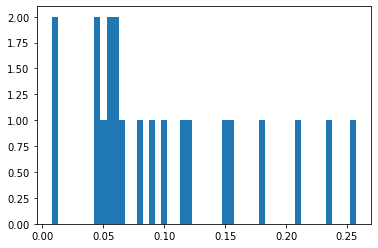

In [41]:
plt.hist(A - B, bins = 50)
print(np.mean(A - B))
plt.show()

# Forecast

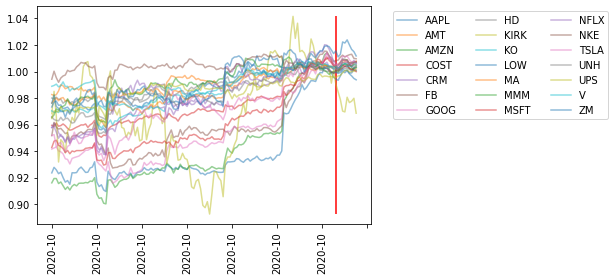

In [42]:
M = YahooStocks.Model(data=data.iloc[0:-3])
M.fitVAR(lags)
M.forecast(10)
M.plot_fcast()

In [43]:
M.fcast.iloc[0].sort_values(ascending = False)

symbol
ZM      1.015562
FB      1.008196
NFLX    1.006435
COST    1.005750
TSLA    1.005577
GOOG    1.004228
MA      1.004022
UNH     1.003882
V       1.003676
AMZN    1.003655
MSFT    1.003231
KO      1.002543
AMT     1.002021
CRM     1.001876
MMM     1.000780
NKE     1.000710
HD      0.999716
LOW     0.999505
UPS     0.995637
AAPL    0.994284
KIRK    0.990436
Name: 126, dtype: float64